# AIPI 590 - XAI | Assignment #7

## Description

Develop a hypothesis and design a study using explainable deep learning methods to test your hypothesis. You can use any deep learning method discussed during the lecture: concept activation vectors, feature visualization, saliency maps, integrated gradients, or occlusion methods.

Hypothesis must be in the form of a null/alternative hypothesis.

Share your result as a visual report. This report can be in the form of a Google Colab, webpage, blog, or PDF and should contain the H0/H1 hypothesis, a brief explanation of the approach, the visualizations and/or explanations, and a summary of your findings. If Google Colab is not your medium of choice, please include source code as a link in your report.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/suneel-nadipalli/xai-assignments-duke-fall24/blob/main/Assignment%203/XAI_Assignment_3_Interpretable_Models.ipynb)

## Suneel Nadipalli

## Hypotheses

H0: Applying a patch to an image does not significantly affect the output of explainable AI methods (e.g., Grad-CAM, saliency maps), and the model’s interpretation of important regions remains consistent.

H1: Applying a patch to an image significantly alters the output of explainable AI methods, leading to a noticeable change in the model’s focus on relevant regions.

## Importing Libraries

In [1]:
!pip install torch torchvision captum matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00


In [2]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import Saliency

from captum.attr import LayerGradCam
from captum.attr import visualization as viz

from captum.attr import IntegratedGradients

import numpy as np

from captum.attr import Saliency, LayerGradCam, IntegratedGradients
from captum.attr import visualization as viz

<ipython-input-2-1a5fe094885f>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


## Getting Data

In [3]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## Loading ResNet model and dataset

In [4]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.9MB/s]


In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Helper Functions

In [6]:
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [7]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    """
    Visualizes the original image, its true label, and the model's top K predictions.

    Args:
        img: The original image tensor.
        label: The true label of the image.
        pred: The model's prediction for the image.
        K (int): The number of top predictions to display.
    """

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    # Display the original image
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    # Calculate top K predictions and their probabilities
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

In [8]:
def place_patch(img, patch):

    """
    Places a given patch on a batch of images.

    Args:
        img: The batch of images.
        patch: The patch tensor to be placed on the images.

    Returns:
        img: The batch of images with the patch placed on random locations.
    """

    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [9]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]

def patch_forward(patch):

    """
    Normalize the input patch within the ImageNet min and max values.

    Args:
        patch: The input patch tensor.

    Returns:
        patch: The transformed patch tensor.
    """

    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [10]:
def eval_patch(model, patch, val_loader, target_class):

    """
    Evaluates the performance of a given patch on a validation set.

    Args:
        model: The model to be evaluated.
        patch: The patch tensor to be evaluated.
        val_loader: The validation data loader.
        target_class: The target class for evaluation.

    Returns:
        tuple: A tuple containing two elements:
            - acc: Accuracy of the model predicting the target class on the validation set.
            - top5: Top-5 accuracy of the model predicting the target class on the validation set.
    """

    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [11]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):

    """
    Trains a patch to fool a given model into predicting a specific target class.

    Args:
        model: The model to be attacked.
        target_class: The target class for the attack.
        patch_size (int): The size of the patch to be trained.
        num_epochs (int): The number of training epochs.

    Returns:
        tuple: A tuple containing two elements:
            - patch.data: The trained patch tensor.
            - dict: A dictionary containing the validation results of the trained patch.
    """

    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [12]:
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)


In [13]:
def get_patches(class_names, patch_sizes):

    """
    Gets or trains patches for a given list of class names and patch sizes.

    Args:
        class_names: A list of class names for which patches are to be retrieved or trained.
        patch_sizes: A list of patch sizes for which patches are to be retrieved or trained.

    Returns:
        dict: A dictionary containing the evaluation results of patches.
    """

    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [14]:
def perform_patch_attack(patch):

    """
    Performs a patch attack on a batch of images.

    Args:
        patch: The patch tensor to be applied to the images.
    """

    patch_batch = exmp_batch.clone()

    print(type(patch_batch))

    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [15]:
def plot_saliency(input_tensor, label):
    saliency = Saliency(pretrained_model)

    # Compute saliency maps
    input_tensor.requires_grad = True
    saliency_map = saliency.attribute(input_tensor, target=label)  # Target 0: class index

    # Visualize saliency map
    saliency_map = saliency_map.squeeze().cpu().detach().numpy()
    # plt.imshow(saliency_map[0], cmap='hot')
    # plt.title('Saliency Map')
    # plt.show()

    return saliency_map[0]

In [16]:
def plot_cam(input_tensor, label):
    layer_gc = LayerGradCam(pretrained_model, pretrained_model.layer4)  # Last convolutional layer

    # Compute Grad-CAM
    gradcam_attr = layer_gc.attribute(input_tensor, target=label)

    # Visualize Grad-CAM
    gradcam_attr = gradcam_attr.squeeze().cpu().detach().numpy()
    # plt.imshow(gradcam_attr, cmap='jet')
    # plt.title('Grad-CAM')
    # plt.show()

    return gradcam_attr

## Part I: Training Patches

In [18]:
exmp_batch, label_batch = next(iter(data_loader))

In [19]:
class_names = ["Doberman"]
patch_sizes = [48]

patch_dict = get_patches(class_names, patch_sizes)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for Doberman and 48: {'acc': 0.9735000133514404, 'top5': 0.9984999895095825}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

In [20]:
norm_batch = exmp_batch.clone()

patch_batch = place_patch(exmp_batch, patch_dict['Doberman'][48]['patch'])

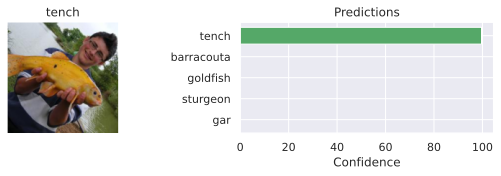

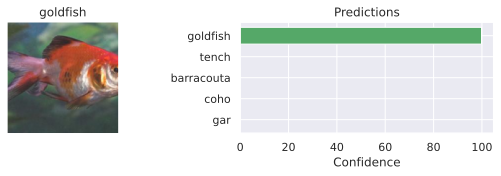

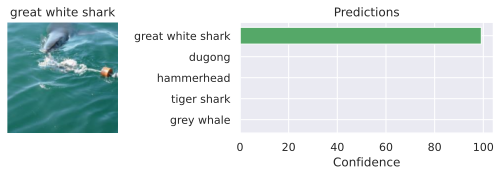

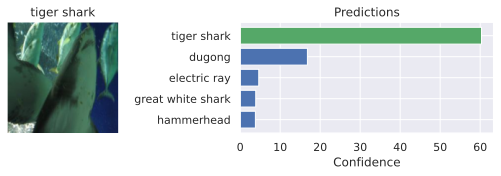

In [21]:
with torch.no_grad():
    patch_preds = pretrained_model(norm_batch.to(device))
for i in range(1,17,5):
    show_prediction(norm_batch[i], label_batch[i], patch_preds[i])

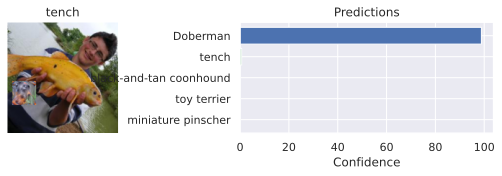

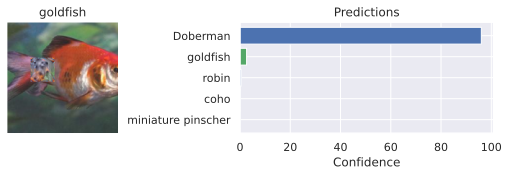

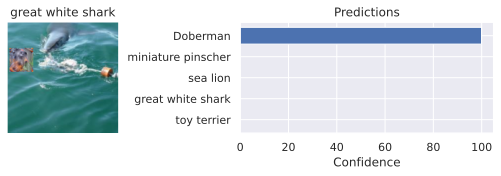

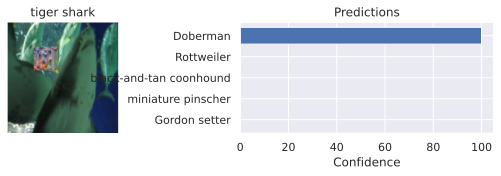

In [22]:
with torch.no_grad():
    patch_preds = pretrained_model(patch_batch.to(device))
for i in range(1,17,5):
    show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

## Part II: Plotting Predictions

In [56]:
def comp_plots(norm_tensor, patch_tensor, label, name):

    norm_img = norm_tensor.cpu().permute(1, 2, 0).numpy()
    norm_img = (norm_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
    norm_img = np.clip(norm_img, a_min=0.0, a_max=1.0)

    patch_img = patch_tensor.cpu().permute(1, 2, 0).numpy()
    patch_img = (patch_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
    patch_img = np.clip(patch_img, a_min=0.0, a_max=1.0)

    fig, ax = plt.subplots(2, 3, figsize=(10,5))

    # Display the original image
    ax[0, 0].imshow(norm_img)
    ax[0, 0].set_title(f"Actual Label: {label_names[label]}")
    ax[0, 0].axis('off')

    pred = pretrained_model(patch_tensor.unsqueeze(0).to(device))

    pred = torch.softmax(pred, dim=-1)

    topk_vals, topk_idx = pred.topk(1, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    ax[1, 0].imshow(patch_img)
    ax[1, 0].set_title(f"Adv. Label: {label_names[topk_idx[0][0]]}")
    ax[1, 0].axis('off')

    label = 0

    norm_cam = plot_cam(norm_tensor.unsqueeze(0).to(device), label)
    ax[0, 1].imshow(norm_cam, cmap='jet')
    ax[0, 1].set_title('Actual Grad CAM')
    ax[0, 1].axis('off')

    patch_cam = plot_cam(patch_tensor.unsqueeze(0).to(device), label)
    ax[1, 1].imshow(patch_cam, cmap='jet')
    ax[1, 1].set_title('Adv. Grad CAM')
    ax[1, 1].axis('off')

    norm_sal = plot_saliency(norm_tensor.unsqueeze(0).to(device), label)
    ax[0, 2].imshow(norm_sal, cmap='hot')
    ax[0, 2].set_title('Actual Saliency')
    ax[0, 2].axis('off')

    patch_sal = plot_saliency(patch_tensor.unsqueeze(0).to(device), label)
    ax[1, 2].imshow(patch_sal, cmap='hot')
    ax[1, 2].set_title('Adv. Saliency')
    ax[1, 2].axis('off')

    plt.savefig(name)

    plt.show()
    plt.close()

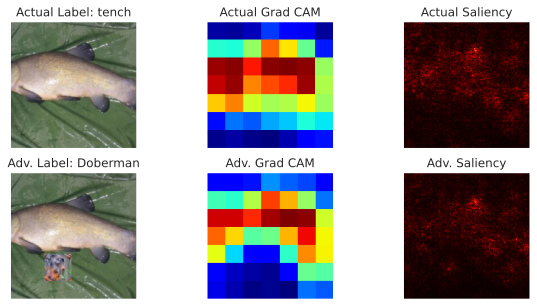

In [57]:
idx = 0

norm_tensor, patch_tensor, label = norm_batch[idx], patch_batch[idx], label_batch[idx]

name = f"outputs/plot_ex_{idx}.png"

comp_plots(norm_tensor, patch_tensor, label, name)

The model slightly focuses additionally on the patch region as well. This is more noticable in the Grad-CAM than the saliency map.

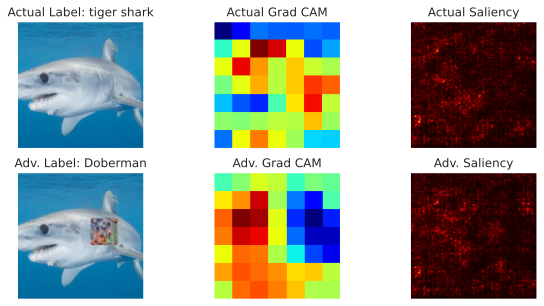

In [59]:
idx = 15

norm_tensor, patch_tensor, label = norm_batch[idx], patch_batch[idx], label_batch[idx]

name = f"outputs/plot_ex_{idx}.png"

comp_plots(norm_tensor, patch_tensor, label, name)

The model slightly focuses additionally on the patch region as well. This is more noticable in the Grad-CAM than the saliency map, but less noticable than in the previous example.

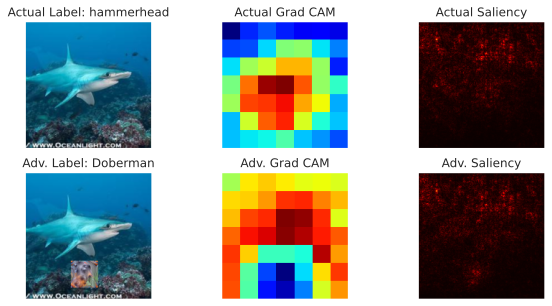

In [60]:
idx = 20

norm_tensor, patch_tensor, label = norm_batch[idx], patch_batch[idx], label_batch[idx]

name = f"outputs/plot_ex_{idx}.png"

comp_plots(norm_tensor, patch_tensor, label, name)

The model slightly focuses additionally on the patch region as well. This is more noticable in the Grad-CAM than the saliency map, but less noticable than in the previous example.

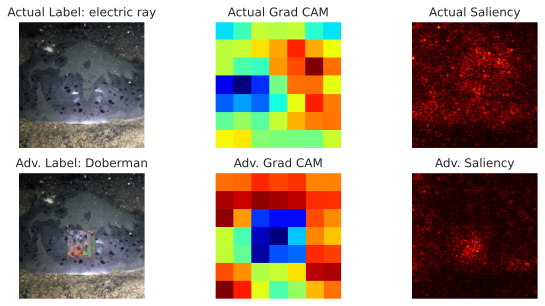

In [61]:
idx = 25

norm_tensor, patch_tensor, label = norm_batch[idx], patch_batch[idx], label_batch[idx]

name = f"outputs/plot_ex_{idx}.png"

comp_plots(norm_tensor, patch_tensor, label, name)

The model significantly shifts its focus on the image towards the patch, almost solely so. This can be clearly seen in the saliency map.

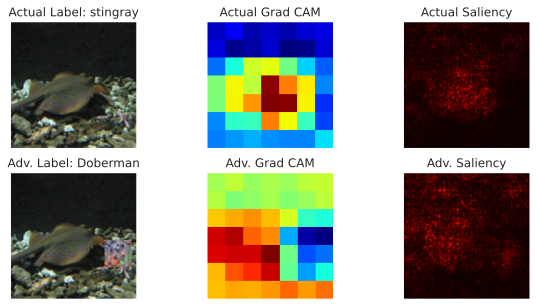

In [62]:
idx = 30

norm_tensor, patch_tensor, label = norm_batch[idx], patch_batch[idx], label_batch[idx]

name = f"outputs/plot_ex_{idx}.png"

comp_plots(norm_tensor, patch_tensor, label, name)

The model slightly focuses additionally on the patch region. But additionally, it causes the model to focus on other unimportant regions of the image it originally didn't. This can be seen clearly from the saliency map.